# **Custom Knowledge ChatGPT with LangChain - Chat with PDFs**






0.   Installs, Imports and API Keys
1.   Loading PDFs and chunking with LangChain
2.   Embedding text and storing embeddings
3.   Creating retrieval function








# 0. Installs, Imports and API Keys

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

c:\Users\vikas\Desktop\pdf_chatbot\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
os.environ["OPENAI_API_KEY"] = "{YOUR_API_KEY}"

# 1. Loading PDFs and chunking with LangChain

In [3]:
# importing required modules
from PyPDF2 import PdfReader

# creating a pdf reader object
reader = PdfReader('ugly_love.pdf')

text = ""

for page in reader.pages:
    text += page.extract_text()


In [4]:
# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

In [5]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0])

langchain.schema.Document

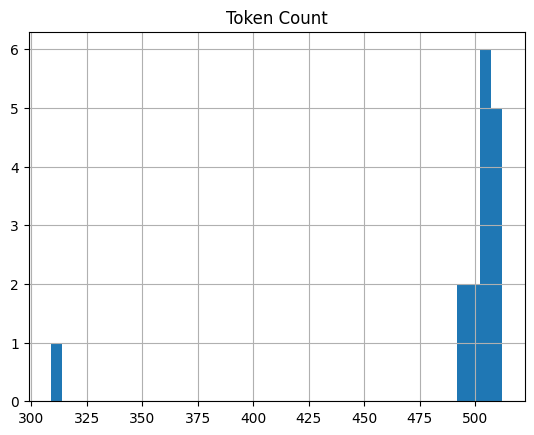

In [6]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

# 2. Embed text and store embeddings

In [7]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

# 3. Setup retrieval function

In [8]:
# Check similarity search is working
query = "Who was tate's brother?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='chapter one\nTATE\n“Somebody stabbed you in the neck, young lady.”\nMy eyes widen, and I slowly turn toward the elderly gentleman\nstanding at my side. He presses the up button on the elevator and faces\nme. He smiles and points to my neck.\n“Your birthmark,” he says.\nMy hand instinctively goes up to my neck, and I touch the dime-\nsized mark just below my ear.\n“My grandfather used to say the placement of a birthmark was the\nstory of how a person lost the battle in their past life. I guess you got\nstabbed in the neck. Bet it was a quick death, though.”\nI smile, but I can’t tell if I should be afraid or entertained. Despite his\nsomewhat morbid opening conversation, he can’t be that dangerous.\nHis curved posture and shaky stance give away that he isn’t a day less\nthan eighty years old. He takes a few slow steps toward one of two\nvelvet red chairs that are positioned against the wall next to the elevator.\nHe grunts as he sinks into the chair and then looks

In [9]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "Who was tate's brother?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

" Corbin was Tate's brother."